In [1]:
import torch
import numpy as np

from data import data_preprocess
from evaluation import metrics
from model import end2end, end2end_crps

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('mpg')

In [3]:
end2end_model = end2end_crps.train_model(x_train, y_train, calibration_threshold = .03)

initial loss:  847.603515625
535 0.030022222222222207 tensor(2.7717, grad_fn=<MeanBackward0>) tensor(1.4396, grad_fn=<MeanBackward0>)
536 0.031044444444444465 tensor(2.8134, grad_fn=<MeanBackward0>) tensor(1.4533, grad_fn=<MeanBackward0>)
537 0.0708555555555555 tensor(2.8941, grad_fn=<MeanBackward0>) tensor(1.4816, grad_fn=<MeanBackward0>)
538 0.07812222222222223 tensor(2.9804, grad_fn=<MeanBackward0>) tensor(1.5145, grad_fn=<MeanBackward0>)
539 0.08569999999999994 tensor(2.9213, grad_fn=<MeanBackward0>) tensor(1.4979, grad_fn=<MeanBackward0>)
540 0.045944444444444454 tensor(2.8372, grad_fn=<MeanBackward0>) tensor(1.4625, grad_fn=<MeanBackward0>)
541 0.04065555555555552 tensor(2.7844, grad_fn=<MeanBackward0>) tensor(1.4388, grad_fn=<MeanBackward0>)
601 0.04026666666666663 tensor(2.7234, grad_fn=<MeanBackward0>) tensor(1.4072, grad_fn=<MeanBackward0>)
602 0.057788888888888924 tensor(2.8226, grad_fn=<MeanBackward0>) tensor(1.4379, grad_fn=<MeanBackward0>)
603 0.13296666666666665 tensor(2

End2end test MAPE:  0.08222726
End2end test RMSE:  2.6189268
End2end test NLLK:  2.6788757
End2end test CRPS:  tensor(1.3603)


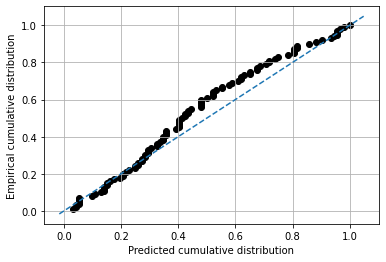

End2end test calibration error when step size is 0.001:  4.1824206049149355
End2end test calibration error when step size is 0.01:  0.4126465028355389
End2end test calibration error when step size is 0.1:  0.04324196597353499


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))